In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import utm

In [2]:
DATE = ['20230302']#, '20230305']
SESSION = ['SM_Lek1']#, 'SE_Lek1']
DRONE = ['P1D1', 'P2D3', 'P3D5']#, 'P2D4', 'P3D5', 'P3D6']

files_directory = '/Volumes/EAS_shared/blackbuck/working/processed/Field_Recording_2023/TestRegistration'

In [3]:
idx = 0
for date in DATE:
    for session in SESSION:
        for drone in DRONE:
            print(date, session, drone)
            
            internal_path = files_directory + '/' + date + '/' + session + '/' + drone
            files = glob.glob(internal_path + '/' + date + '_' + session + '_' + drone + '*_3D_trajectories.csv')

            for file in sorted(files):
                tmp = pd.read_csv(file)
                tmp['drone'] = drone
                
                if idx != 0:
                    df = pd.concat((df, tmp), axis=0)
                else:
                    df = tmp
                
                idx += 1

20230302 SM_Lek1 P1D1
20230302 SM_Lek1 P2D3
20230302 SM_Lek1 P3D5


### Plot data on a georeferenced territory map

In [4]:
# Load dataset with longitude, latitude and altitude for all marked territories from the orthomosaic
map_coordinates = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Metashape/TalChhapar/output/territories_xyz.txt', header=None)
map_coordinates = map_coordinates.iloc[:,:4]
map_coordinates.columns = ['Point', 'Longitude', 'Latitude', 'Altitude']
map_coordinates.head()

,Point,Longitude,Latitude,Altitude
0,1,74.436945,27.800021,287.9558
1,2,74.436766,27.800038,288.3593
2,3,74.436602,27.799934,288.8230
3,4,74.436794,27.799810,288.5657
4,5,74.437163,27.799771,287.6457


In [5]:
for idx, ID in enumerate(np.unique(df['drone'])):
    df.loc[df['drone'] == ID, 'drone_id'] = idx

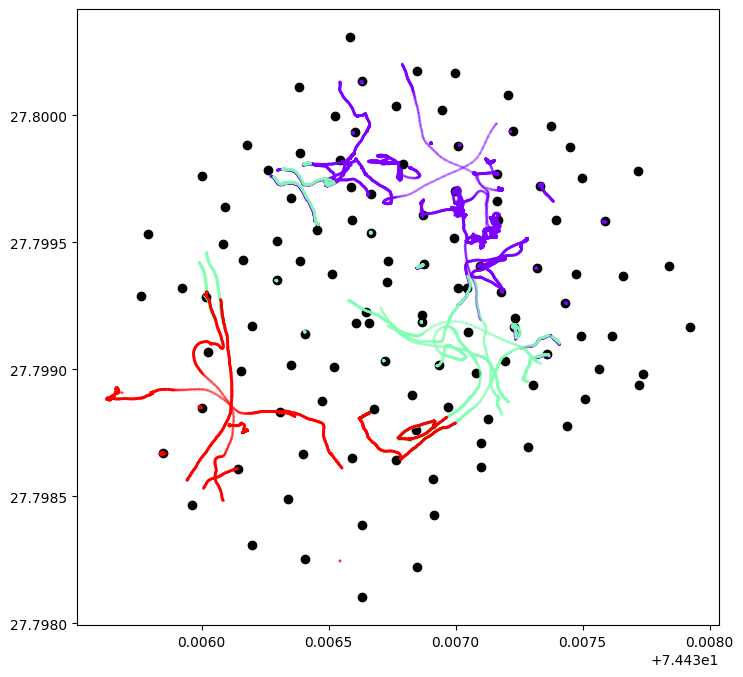

In [6]:
# Set the figure size (width, height) in inches
plt.figure(figsize=(12, 8))  # You can adjust these values as needed

# Create the scatter plots
plt.scatter(map_coordinates['Longitude'], map_coordinates['Latitude'], c='black')
plt.scatter(df['x'], df['y'], c=df['drone_id'], cmap='rainbow', s=1, alpha=0.1)

# Maintain equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()